In [25]:
import os

import matplotlib.pyplot as plt
import numpy as np

import bayesflow as bf


from bayesflow.diagnostics.metrics import classifier_two_sample_test
from bayesflow.metrics.maximum_mean_discrepancy import maximum_mean_discrepancy

from inverse_kinematics import InverseKinematicsModel

In [2]:
# Observation from https://arxiv.org/abs/2101.10763
obs = {"observables": np.array([0, 1.5])}

In [3]:
files = os.listdir("samples")


kinematics_samples = {
    f.replace("_inverse_kinematics.npy", ""): np.load(os.path.join("samples", f)) for f in files if "kinematics" in f
}

In [4]:
kinematics_samples.keys()

dict_keys(['abc', 'diffusion_edm_ve', 'diffusion_cosine_noise', 'consistency_model', 'flow_matching', 'diffusion_edm_vp', 'ot_flow_matching', 'diffusion_cosine_v', 'stable_consistency_model', 'diffusion_cosine_F'])

In [6]:
titles = {
    "abc": "ABC-SMC",
    "diffusion_edm_ve": "EDM VE",
    "diffusion_edm_vp": "EDM VP",
    "diffusion_cosine_noise": "Cosine Noise",
    "diffusion_cosine_v": r"Cosine $\mathbf{v}$",
    "diffusion_cosine_F": r"Cosine $\mathbf{F}$",
    "flow_matching": "Flow Matching",
    "ot_flow_matching": "Flow Matching (OT)",
    "consistency_model": "Discrete Consistency",
    "stable_consistency_model": "Continuous Consistency"
}


colors = {
    "abc": "maroon",
    "diffusion_edm_ve": "#FB9A99",
    "diffusion_edm_vp": "#E7298A",
    "diffusion_cosine_noise": "#54278F",
    "diffusion_cosine_v": "#9E9AC8",
    "diffusion_cosine_F": "#7570B3",
    "flow_matching": "#1B9E77",
    "ot_flow_matching": "#33A02C",
    "consistency_model": "#D95F02",
    "stable_consistency_model": "#E6AB02"
}

Once again, C2ST turns out to be a "bad" metric that cannot differentiate well between models. Classifiers tend to pick up trivial statistical differences (e.g., scale) and do not focus on the overall quality of the posterior. MMD differentiates decisively in this case.

In [36]:
# Compute C2ST scores

approx_ground_truth = kinematics_samples["abc"]

models = [m for m in list(titles.keys()) if m != "abc"]

c2st_results = {k: None for k in models}
mmd_results = {k: None for k in models}

for m in models:
    c2st_results[m] = classifier_two_sample_test(kinematics_samples[m], approx_ground_truth)
    mmd_results[m] = maximum_mean_discrepancy(kinematics_samples[m], approx_ground_truth).detach().cpu().item()

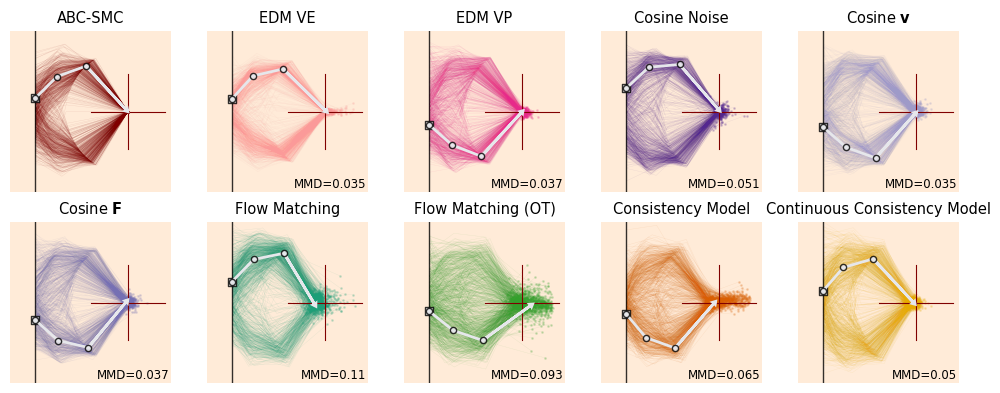

In [46]:
fig, axarr = plt.subplots(2, len(kinematics_samples) // 2, figsize=(10, 4), subplot_kw=dict(box_aspect=1), squeeze=False)

for name, ax in zip(titles, axarr.flat):
     m = InverseKinematicsModel(linecolors=[colors[name]] * 3)
     m.update_plot_ax(ax, kinematics_samples[name][:1000], obs["observables"][::-1], exemplar_color="#e6e7eb")

for title, ax in zip(titles, axarr.flat):
    ax.grid(False)
    ax.patch.set_facecolor('#FFE5CC')
    ax.patch.set_alpha(0.75)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.spines["bottom"].set_alpha(0.0)
    ax.spines["top"].set_alpha(0.0)
    ax.spines["right"].set_alpha(0.0)
    ax.spines["left"].set_alpha(0.0)
    ax.set_aspect('equal')
    ax.set_title(titles[title], fontsize=10.5)

    if title != "abc":
        metric = mmd_results[title]

        ax.text(
            0.99, 0.01,
            f"MMD={metric:.2g}",
            transform=ax.transAxes,
            ha="right", va="bottom",
            fontsize=8.5,
            color="black"
        )

fig.tight_layout()

In [47]:
fig.savefig("plots/inv_kinematics_samples.pdf", dpi=300)